True
Time elapsed 19.652162790298462 sec

Failed due less than 30 stars
False
coeff_PP: 1.0700000000000001e-11
Time elapsed 30.9246563911438 sec

Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
False
coeff_PP: 0.0001188888984
Time elapsed 50.20440864562988 sec

Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
False
coeff_PP: 0.0002377777861
Time elapsed 70.57905387878418 sec

Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?)
Failed due not within 10% (?

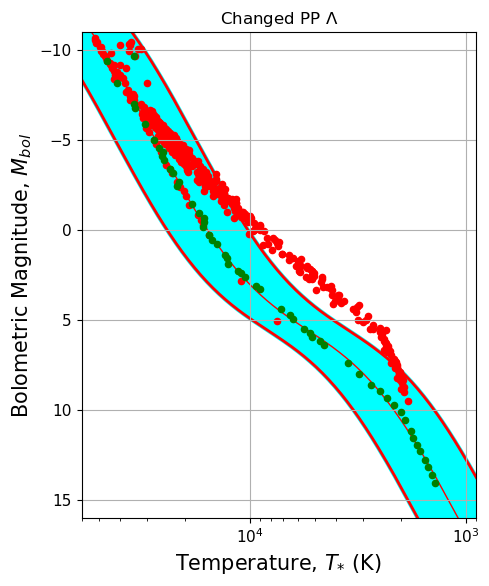

True
Time elapsed 236.96710753440857 sec

True
power_PP: 2.0
Time elapsed 252.48799657821655 sec

True
power_PP: 2.4444444444444446
Time elapsed 269.0776791572571 sec

True
power_PP: 2.888888888888889
Time elapsed 285.42534255981445 sec

True
power_PP: 3.333333333333333
Time elapsed 302.1875638961792 sec

True
power_PP: 3.7777777777777777
Time elapsed 319.07912516593933 sec

True
power_PP: 4.222222222222222
Time elapsed 336.2891502380371 sec

True
power_PP: 4.666666666666666
Time elapsed 354.65629744529724 sec

True
power_PP: 5.111111111111111
Time elapsed 372.8095998764038 sec

True
power_PP: 5.555555555555555
Time elapsed 390.68133997917175 sec

Failed due not within 10% (?)
False
power_PP: 6.0
Time elapsed 409.19349694252014 sec


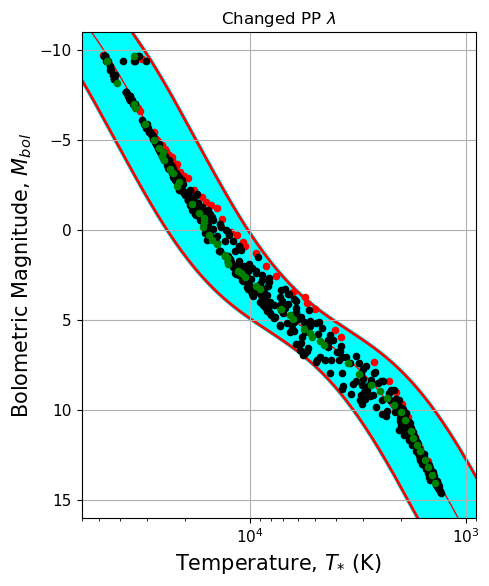

True
Time elapsed 427.1812074184418 sec

True
coeff_CNO: 8.239999999999999e-30
Time elapsed 442.1242890357971 sec

Failed due not within 10% (?)
False
coeff_CNO: 9.155556288000001e-23
Time elapsed 455.1538863182068 sec

Failed due not within 10% (?)
False
coeff_CNO: 1.8311111752000001e-22
Time elapsed 467.9564082622528 sec

True
coeff_CNO: 2.7466667216e-22
Time elapsed 480.55135560035706 sec

True
coeff_CNO: 3.6622222680000002e-22
Time elapsed 493.06324219703674 sec

Failed due not within 10% (?)
False
coeff_CNO: 4.577777814399999e-22
Time elapsed 505.02415585517883 sec

Failed due not within 10% (?)
False
coeff_CNO: 5.4933333608e-22
Time elapsed 517.0292429924011 sec

True
coeff_CNO: 6.4088889072e-22
Time elapsed 529.902090549469 sec

Failed due not within 10% (?)
False
coeff_CNO: 7.3244444536e-22
Time elapsed 542.028418302536 sec

Failed due not within 10% (?)
Failed due not within 10% (?)
False
coeff_CNO: 8.24e-22
Time elapsed 554.1046426296234 sec


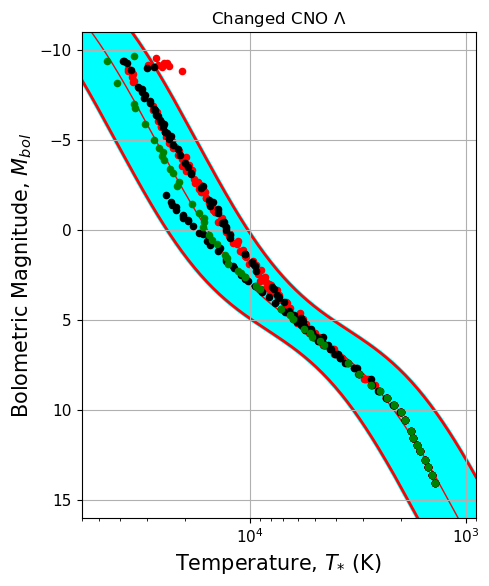

True
Time elapsed 571.6032304763794 sec

True
power_PP: 17.9
Time elapsed 586.7536373138428 sec

True
power_PP: 18.34444444444444
Time elapsed 601.8992891311646 sec

True
power_PP: 18.788888888888888
Time elapsed 615.6657614707947 sec

Failed due not within 10% (?)
False
power_PP: 19.23333333333333
Time elapsed 629.17045545578 sec

Failed due not within 10% (?)
False
power_PP: 19.677777777777777
Time elapsed 642.9643740653992 sec

True
power_PP: 20.12222222222222
Time elapsed 657.2418897151947 sec

True
power_PP: 20.566666666666666
Time elapsed 671.2961912155151 sec

True
power_PP: 21.01111111111111
Time elapsed 683.8047456741333 sec

True
power_PP: 21.455555555555556
Time elapsed 695.6431219577789 sec

Failed due not within 10% (?)
False
power_PP: 21.9
Time elapsed 706.4350683689117 sec


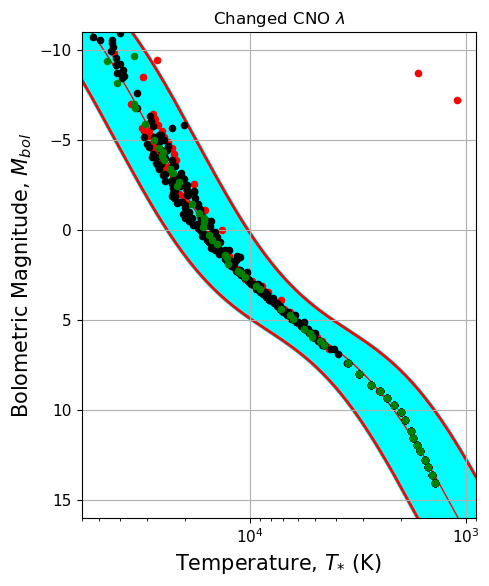

Main loop finished.


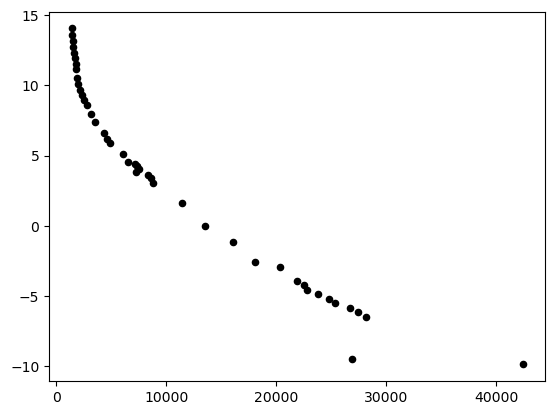

In [2]:
# Nuclear Team

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint, ode
from scipy import optimize
import os
from numba import jit, njit, vectorize
from scipy.optimize import curve_fit

#Keep track of how long code runs
import time
start_time = time.time()

# Constants
hbar = 1.055e-34 # J.s
k = 1.381e-23 # J/K
sigmaSB = 5.670e-8 # W/(m^2 K^4)
sig_H = 4.4e-29 #m2 #hydrogen crossection

G = 6.674e-11 # N.m^2/kg^2
c = 2.998e8 # m/s

a = 4. * sigmaSB/c # J/(m^3 K^4)
gamma = 5./3. # For simple atomic gases and fully ionized gases       VALUE? yes

me = 9.109e-31 # kg
mp = 1.673e-27 # kg

M_solar = 1.989e30 # kg
R_solar = 6.9634e8 # m
L_solar = 3.827e26 # W


# Properties of the star
X = 0.734 # Hydrogen       VALUE? yes
Y = 0.25 # Helium          VALUE? yes
Z = 0.016 # Metallicity     VALUE? yes
assert (X + Y + Z == 1.)


# Necessary Functions
def mu_fn(X, Y, Z):
    return np.power(2*X + 0.75*Y + 0.5*Z, -1)

mu_fn = njit()(mu_fn)

def P_fn(ro, T):
    mu1 = mu_fn(X, Y, Z)
    
    degenerate_P = ((3 * (np.pi)**2)**(2./3.) * hbar**2)/(5. * me) * np.power(ro/mp, 5./3.)
    ideal_gas_P = (k * T * ro)/(mu1 * mp)
    photon_gas_P = (a/3.) * np.power(T, 4)
    
    return ( degenerate_P + ideal_gas_P + photon_gas_P )

P_fn = njit()(P_fn)

def diP_diro_fn(ro, T):
    mu2 = mu_fn(X, Y, Z)
    
    degenerate_diP_diro = ((3 * (np.pi)**2)**(2./3.) * hbar**2)/(3. * me * mp) * np.power(ro/mp, 2./3.)
    ideal_gas_diP_diro = (k * T)/(mu2 * mp)
    
    return ( degenerate_diP_diro + ideal_gas_diP_diro )

diP_diro_fn = njit()(diP_diro_fn)

def diP_diT_fn(ro, T):
    mu3 = mu_fn(X, Y, Z)
    
    ideal_gas_diP_diT = (k * ro)/(mu3 * mp)
    photon_gas_diP_diT = (4. * a/3.) * np.power(T, 3)
    
    return ( ideal_gas_diP_diT + photon_gas_diP_diT )

diP_diT_fn = njit()(diP_diT_fn)

def epsilon_PP_fn(ro, T, coeff, powr):
    ro5 = ro * 1e-5 # kg/m^3
    T6 = T * 1e-6 # K

    return ( coeff * ro5 * X**2 * np.power(T6, powr) ) # W/kg

epsilon_PP_fn = njit()(epsilon_PP_fn)

def epsilon_CNO_fn(ro, T, coeff, powr):
    ro5 = ro * 1e-5 # kg/m^3
    T6 = T * 1e-6 # K
    Xcno = 0.03 * X

    return ( coeff * ro5 * X * Xcno * np.power(T6, powr) ) # W/kg

epsilon_CNO_fn = njit()(epsilon_CNO_fn)

def epsilon_fn(ro, T, coeff_PP, power_PP, coeff_CNO, power_CNO):
    epsilon_PP_ = epsilon_PP_fn(ro, T, coeff_PP, power_PP)
    epsilon_CNO_ = epsilon_CNO_fn(ro, T, coeff_CNO, power_CNO)
    
    return ( epsilon_PP_ + epsilon_CNO_ )

epsilon_fn = njit()(epsilon_fn)

def kappa_es_fn():
    return ( 0.02 * (1 + X) ) # m^2/kg

kappa_es_fn = njit()(kappa_es_fn)

def kappa_ff_fn(ro, T):
    ro3 = ro * 1e-3 # kg/m^3

    return ( 1.0e24 * (Z + 0.0001) * np.power(ro3, 0.7) * np.power(T, -3.5) ) # m^2/kg

kappa_ff_fn = njit()(kappa_ff_fn)

def kappa_H_fn(ro, T):
    ro3 = ro * 1e-3 # kg/m^3

    return ( 2.5e-32 * (Z/0.02) * np.power(ro3, 0.5) * np.power(T, 9) ) # m^2/kg

kappa_H_fn = njit()(kappa_H_fn)

def kappa_fn(ro, T):
    kappa_es_ = kappa_es_fn()
    kappa_ff_ = kappa_ff_fn(ro, T)
    kappa_H_ = kappa_H_fn(ro, T)
    
    return np.power( np.power(kappa_H_, -1) + np.power(np.maximum(kappa_es_, kappa_ff_), -1) , -1)

kappa_fn = njit()(kappa_fn)

def delta_tau_fn(r, ro, T, M, L):
    return ( kappa_fn(ro, T) * np.power(ro, 2) * np.power(np.abs(dro_dr_fn(r, ro, T, M, L)), -1) )

delta_tau_fn = njit()(delta_tau_fn)

def stop_delta_tau(r, y, coeff_PP, power_PP, coeff_CNO, power_CNO):
    return ( delta_tau_fn(r, y[0], y[1], y[2], y[3]) - 1e-2 )

stop_delta_tau = njit()(stop_delta_tau)

def stop_mass(r, y, coeff_PP, power_PP, coeff_CNO, power_CNO):
    return ( y[2] - 1e3 * M_solar )

stop_mass = njit()(stop_mass)

stop_delta_tau.terminal = True
stop_mass.terminal = True

# Set of differential equations
def dro_dr_fn(r, ro, T, M, L):
    return ( -(G * M * ro * np.power(r, -2) + diP_diT_fn(ro, T) * dT_dr_fn(r, ro, T, M, L) ) * np.power(diP_diro_fn(ro, T), -1) )

dro_dr_fn = njit()(dro_dr_fn)

def dT_dr_fn(r, ro, T, M, L):
    radiative_diffusion = 3 * kappa_fn(ro, T) * ro * L * np.power(16 * np.pi * a * c * np.power(T, 3) * np.power(r, 2), -1)
    convection = (1 - (1/gamma)) * G * M * ro * T * np.power(np.power(r, 2) * P_fn(ro, T), -1)
    
    return ( -1. * np.minimum(radiative_diffusion, convection) )    

dT_dr_fn = njit()(dT_dr_fn)

def dM_dr_fn(r, ro):
    return ( 4 * np.pi * np.power(r, 2) * ro )

dM_dr_fn = njit()(dM_dr_fn)

def dL_dr_fn(r, ro, T, coeff_PP, power_PP, coeff_CNO, power_CNO):
    return ( 4 * np.pi * np.power(r, 2) * ro * epsilon_fn(ro, T, coeff_PP, power_PP, coeff_CNO, power_CNO) )

dL_dr_fn = njit()(dL_dr_fn)

def dtau_dr_fn(ro, T):
    return ( kappa_fn(ro, T) * ro )

dtau_dr_fn = njit()(dtau_dr_fn)

#Function containing set of coupled ODEs
def func(r_, vec, coeff_PP, power_PP, coeff_CNO, power_CNO):
    ro_ = vec[0]
    T_ = vec[1]
    M_ = vec[2]
    L_ = vec[3]
    tau_ = vec[4]
    
    dro = dro_dr_fn(r_, ro_, T_, M_, L_)
    dT = dT_dr_fn(r_, ro_, T_, M_, L_)
    dM = dM_dr_fn(r_, ro_)
    dL = dL_dr_fn(r_, ro_, T_, coeff_PP, power_PP, coeff_CNO, power_CNO)
    dtau = dtau_dr_fn(ro_, T_)
    
    #return np.array([dro, dT, dM, dL, dtau], float)
    return [dro, dT, dM, dL, dtau]
    
func = njit()(func)

#function to find the radius, which is called in f
def f_subpart(r_subpart, tau_subpart, L_subpart, T_subpart):
    # Index of "infinity"
    idx_stop_subpart = len(r_subpart) - 1

    # Find stellar radius
    tau_difference = (tau_subpart[idx_stop_subpart] - tau_subpart) - 2/3
    idx_radius_subpart = np.argmin(np.abs(tau_difference))#.argmin()

    #Interpolate in between r points around found radius to be more precise
    idx_before = idx_radius_subpart - 1
    idx_now = idx_radius_subpart
    idx_after = idx_radius_subpart + 1
    
    r_before = r_subpart[idx_before]
    r_now = r_subpart[idx_now]
    r_after = r_subpart[idx_after]
    
    tau_before = tau_difference[idx_before]
    tau_now = tau_difference[idx_now]
    tau_after = tau_difference[idx_after]

    T_before = T_subpart[idx_before]
    T_now = T_subpart[idx_now]
    T_after = T_subpart[idx_after]

    L_before = L_subpart[idx_before]
    L_now = L_subpart[idx_now]
    L_after = L_subpart[idx_after]
    
    m_tau_before = (tau_before - tau_now)/(r_before - r_now) 
    b_tau_before = tau_before - r_before*m_tau_before
    m_tau_after = (tau_after - tau_now)/(r_after - r_now)
    b_tau_after = tau_after - r_after*m_tau_after
    if m_tau_before == 0:
        m_tau_before = 1
    if m_tau_after == 0:
        m_tau_after = 1
    
    m_T_before = (T_before - T_now)/(r_before - r_now) 
    b_T_before = T_before - r_before*m_T_before
    m_T_after = (T_after - T_now)/(r_after - r_now)
    b_T_after = T_after - r_after*m_T_after
    if m_T_before == 0:
        m_T_before = 1
    if m_T_after == 0:
        m_T_after = 1

    m_L_before = (L_before - L_now)/(r_before - r_now) 
    b_L_before = L_before - r_before*m_L_before
    m_L_after = (L_after - L_now)/(r_after - r_now)
    b_L_after = L_after - r_after*m_L_after
    if m_L_before == 0:
        m_L_before = 1
    if m_L_after == 0:
        m_L_after = 1

    r_zero_before = -1*b_tau_before/m_tau_before
    r_zero_after = -1*b_tau_after/m_tau_after
    
    if tau_before*tau_now < 0:
        r_radius = r_zero_before
        T_radius = m_T_before*r_radius + b_T_before
        L_radius = m_L_before*r_radius + b_L_before
    elif tau_after*tau_now < 0:
        r_radius = r_zero_after
        T_radius = m_T_after*r_radius + b_T_after
        L_radius = m_L_after*r_radius + b_L_after

    #Now retrieve the r, T, and L values at the surface:
    R_subpart = r_radius #r_subpart[idx_radius_subpart]
    L_R_subpart = L_radius #L_subpart[idx_radius_subpart]
    T_R_subpart = T_radius #T_subpart[idx_radius_subpart]
    
    #Define the lumonisity based on Stefan-Boltzmann law:
    L_SB_subpart = 4*np.pi*sigmaSB*np.power(R_subpart,2)*np.power(T_R_subpart,4)
    
    #Equation we are finding roots of:
    eq_subpart = (L_R_subpart - L_SB_subpart) * np.power(L_R_subpart*L_SB_subpart,-0.5)

    return eq_subpart, R_subpart, T_R_subpart, L_R_subpart

f_subpart = njit()(f_subpart)

# Function that integrates and returns the relative error for surface luminosity, surface temperature, and surface luminosity
def f(ro_c, T_c, coeff_PP, power_PP, coeff_CNO, power_CNO):
    # Integration
    # Integration r-array
    r0 = 1e-5 # m
    rf = 5e3*R_solar # m

    # Central (initial) values
    M_c = (4. * np.pi/3.) * r0**3 * ro_c # kg
    L_c = (4. * np.pi/3.) * r0**3 * ro_c * epsilon_fn(ro_c, T_c, coeff_PP, power_PP, coeff_CNO, power_CNO) # W
    #tau_c = dtau_dr_fn(ro_c, T_c) #??? #should not matter
    tau_c = 4*np.pi*np.power(r0, 3)*ro_c*sig_H*r0/(3*mp) #calculated from 0 to ro with math, assume only Hydrogen there, close enough
    
    # Initial value array
    vec0 = np.array([ro_c, T_c, M_c, L_c, tau_c], float)

    # Use solve_ivp to integrate coupled ODEs
    y_arr = solve_ivp(func, (r0, rf), vec0, method='RK45', events=(stop_delta_tau, stop_mass), args=(coeff_PP, power_PP, coeff_CNO, power_CNO))
    
    r = y_arr.t
    ro = y_arr.y[0]
    T = y_arr.y[1]
    M = y_arr.y[2]
    L = y_arr.y[3]
    tau = y_arr.y[4]

    #r, ro, T, M, L, tau = f_solve_ivp(func, r0, rf, vec0, coeff_PP, power_PP, coeff_CNO, power_CNO)
    
    # Values that we will need for the individual reports
    #P = P_fn(ro, T)
    #dL_dr = dL_dr_fn(r, ro, T)
    #dT_dr = dT_dr_fn(r, ro, T, M, L)
    #epsilon_PP = epsilon_PP_fn(ro, T)
    #epsilon_CNO = epsilon_CNO_fn(ro, T)
    #kappa_es = kappa_es_fn()
    #kappa_ff = kappa_ff_fn(ro, T)
    #kappa_H = kappa_H_fn(ro, T)
    #kappa = kappa_fn(ro, T)
    
    eq, R, T_R, L_R = f_subpart(r, tau, L, T)
    
    return ( eq, R, T_R, L_R )


def bisection_subpart(mid_subpart, f_mid_subpart, low_subpart, f_low_subpart, high_subpart, f_high_subpart):
    new_high_subpart = high_subpart
    new_f_high_subpart = f_high_subpart
    new_low_subpart = low_subpart
    new_f_low_subpart = f_low_subpart
    new_mid_subpart = mid_subpart
    
    if (f_low_subpart*f_mid_subpart <= 0):
        new_high_subpart = mid_subpart
        new_f_high_subpart = f_mid_subpart
    else :
        new_low_subpart = mid_subpart
        new_f_low_subpart = f_mid_subpart

    new_mid_subpart = 0.5*(new_low_subpart + new_high_subpart)
    percent_change_subpart = 100*np.abs((new_mid_subpart - mid_subpart)/mid_subpart)
    return new_mid_subpart, new_low_subpart, new_f_low_subpart, new_high_subpart, new_f_high_subpart, percent_change_subpart

bisection_subpart = njit()(bisection_subpart)

# Bisection algorithm
def bisection(f, ro_min, ro_max, T_c, coeff_PP, power_PP, coeff_CNO, power_CNO) :    
    # This version of bisection algorithm runs until a specific error criterion is met, stop when ro (AKA mid) saturates
    low = ro_min
    f_low, R_low, T_low, L_low = f(low, T_c, coeff_PP, power_PP, coeff_CNO, power_CNO)
    high = ro_max
    f_high, R_high, T_high, L_high = f(high, T_c, coeff_PP, power_PP, coeff_CNO, power_CNO)
    
    #assert f_low*f_high < 0
    # Bisection method assumes f_low and f_high start with opposite signs
    if f_low*f_high < 0:

        mid = 0.5*(low+high)
        f_mid, R_mid, T_mid, L_mid = f(mid, T_c, coeff_PP, power_PP, coeff_CNO, power_CNO)
        
        # Max error desired
        change_err = 0.01 #%
        
        count = 0 #keep track of how many iterations
        previous_mid = mid #first mid value
        percent_change = 100 #first percent change value, just has to be big (bigger than change_err)
        
        while (percent_change > change_err):
            #count += 1
            mid, low, f_low, high, f_high, percent_change = bisection_subpart(mid, f_mid, low, f_low, high, f_high)
            f_mid, R_mid, T_mid, L_mid = f(mid, T_c, coeff_PP, power_PP, coeff_CNO, power_CNO)
        #print(count)
        
        T_mid = np.power(L_mid/(4*np.pi*sigmaSB*np.power(R_mid,2)), 1./4.)
        #mid is ro_core, do not need to return it with the function
    else:
        T_mid = 0
        L_mid = 0

    return (T_mid, L_mid )


def Mag(luminosity_array):
    return -2.5*np.log10(luminosity_array/(40.12*L_solar))

Mag = njit()(Mag)


#remove 'bad' point with a chosen distance - function
def outlier_remove(data, limit_array):
    for jj in limit_array:#[2e4, 2e4, 1e4, 1e4, 8e3, 6e3, 4e3]:
        outlier = []
        for ii in range(np.shape(data)[0]-3):
            d1 = np.power(np.power((data[ii,3] - data[ii+1,3]),2) + np.power((data[ii,1] - data[ii+1,1]),2), 0.5)
            d2 = np.power(np.power((data[ii+1,3] - data[ii+2,3]),2) + np.power((data[ii+1,1] - data[ii+2,1]),2), 0.5)
            d3 = np.power(np.power((data[ii+2,3] - data[ii+3,3]),2) + np.power((data[ii+2,1] - data[ii+3,1]),2), 0.5)
            ave_distance = (d1 + d2 + d3)/3
            if ave_distance > jj:
                outlier.append(ii+1)
        data = np.delete(data, outlier, axis=0)
    return data

#The main sequence function which contains all these other functions
def main_sequence(N_temp, coeff_PP, power_PP, coeff_CNO, power_CNO):
    main_sequence_2D_array = np.zeros([N_temp, 4], float)
    main_sequence_2D_array[:,0] = np.linspace(2e6, 3.4e7, N_temp) #T_c value inside 2D array
    
    for ii in range(N_temp):
        T_surface, L_surface = bisection(f, 0.3e3, 500e3, main_sequence_2D_array[ii,0], coeff_PP, power_PP, coeff_CNO, power_CNO)
        main_sequence_2D_array[ii, 1] = T_surface
        main_sequence_2D_array[ii, 2] = L_surface
        
    main_sequence_2D_array[:, 3] = Mag(main_sequence_2D_array[:,2])
    
    #REMOVE OUTLIERS HERE##################
    #cut datapoint bellow T_surf of 1000K
    main_sequence_2D_array = np.delete(main_sequence_2D_array, np.where(main_sequence_2D_array[:,1] < 1000), axis=0)

    #Sort the array by increasing M_bol since might not be in order
    main_sequence_2D_array[np.argsort(main_sequence_2D_array[:, 3])]
    #Then remove the points which deviate more
    main_sequence_2D_array = outlier_remove(main_sequence_2D_array, [2e4, 2e4, 1e4, 1e4, 8e3, 6e3, 4e3])
    ################################

    # outliers already removed.
    return main_sequence_2D_array

#Fitting function of the main sequence for 10% err
def eq(x, a, b, c, d, m):
    y = a*np.sin(b*(x-c))+d*(x-c)+m
    return y

eq = njit()(eq)

#Function limits for plot
#commented out the fitting, was just for the unmodified main sequence
#param, covar = optimize.curve_fit(eq, np.log10(main_sequence_data[:,1]), main_sequence_data[:,3])
param = [  1.58703426 ,  4.48662193 ,  3.73342777, -15.02798037 ,  5.54278427]
fitlogT = np.linspace(2.9, 4.8, 200)
fitM = eq(fitlogT, param[0], param[1], param[2], param[3], param[4])
fitM_lower = eq(fitlogT, param[0], param[1], 0.95*param[2], param[3], param[4]) #-10% shift in log(T)
fitM_upper = eq(fitlogT, param[0], param[1], 1.05*param[2], param[3], param[4]) #+10% shift in log(T)


def is_good(main_sequence_2D_array):
    aa = True
    
    #check that all points are within blue regions (10% known main sequence)
    for ii in range(np.shape(main_sequence_2D_array)[0]):
        if eq(np.log10(main_sequence_2D_array[ii,1]), param[0], param[1], 0.95*param[2], param[3], param[4]) > main_sequence_2D_array[ii,3] or eq(np.log10(main_sequence_2D_array[ii,1]), param[0], param[1], 1.05*param[2], param[3], param[4]) < main_sequence_2D_array[ii,3]:
            aa = False
            print("Failed due not within 10% (?)")

    #Sometimes just does not compute for many star, also add condition that is only so many stars left, sequence params are bad
    if np.shape(main_sequence_2D_array)[0] < 30:
        aa = False
        print("Failed due less than 30 stars")
    return aa

# The big loop that cycles through the coefficients
for i in range(4):

    # Moved plot formatting from the bottom to here, hopefully still works
    # All the plot formatting stuff has to repeat every time you call show()
    plt.figure(figsize=(5,6))   # set plot size
                                # this one has to go before all the other formatting shit
    plt.xscale('log')
    ## Plot formatting
    plt.yticks(fontsize=11, rotation=0) #adjust axis tick numbers font size
    plt.xticks(fontsize=11, rotation=0) #adjust axis tick numbers font size
    plt.xlabel('Temperature, $T_{*}$ (K)', fontsize=15)
    plt.ylabel('Bolometric Magnitude, $M_{bol}$', fontsize=15)
    plt.title('HR Diagram', fontsize=16)
    #plt.legend()
    plt.xlim(6e4, 0.9e3)
    plt.ylim(16, -11)
    #plt.xscale('log')
    #plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()

    # Plot the fitted 10% lines
    plt.plot(np.power(10,fitlogT), fitM, '-r', linewidth=1, zorder=1)
    plt.plot(np.power(10,fitlogT), fitM_lower, '-r', linewidth=2, zorder=1)
    plt.plot(np.power(10,fitlogT), fitM_upper, '-r', linewidth=2, zorder=1)

    # Plot the blue shit.
    for kk in np.linspace(0.95, 1.05, 30):
        plt.plot(np.power(10,fitlogT), eq(fitlogT, param[0], param[1], kk*param[2], param[3], param[4]), 'cyan',
                 linewidth=3, zorder=0)

    # Energy generation rate parameters (vary for our group project)
    coeff_PP = 1.07e-7    # "big lambda" for PP chain
    power_PP = 4.         # "little lambda" for PP chaing
    coeff_CNO = 8.24e-26  # "big lambda" for CNO cycle
    power_CNO = 19.9      # "little lambda" for CNO cycle

    # Plot the OG main sequence
    main_sequence_data = main_sequence(100, coeff_PP, power_PP, coeff_CNO, power_CNO)

    check = is_good(main_sequence_data)
    print(check)

    # Plot the main sequence data, change the colour if not good.
    if check == True:
        plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='g', s=20, zorder=30)
    elif check == False:
        plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='r', s=20, zorder=30)

    #Check how long the program runs for
    print("Time elapsed", time.time() - start_time, "sec")


    # Vary nuclear parameters (change values to make it 10%)
    list_length = 10

    ## PP chain
    coeff_PP_factor = 1e4  # just picked this arbitratily - change over small range
                                # changes the range over which we vary PP coefficient
    coeff_PP_list = np.linspace(coeff_PP/coeff_PP_factor, coeff_PP*coeff_PP_factor, 10)
    power_PP_difference = 2     # picked arbitratily - change over large range
                                # changes tha ranve over which we vary PP power
    power_PP_list = np.linspace(power_PP-power_PP_difference, power_PP+power_PP_difference, 10)
                                # do we want to try negative values for this one?

    ## CNO cycle
    coeff_CNO_factor = 1e4  # just picked this arbitratily - change over small range
                                # changes the range over which we vary CNO coefficient
    coeff_CNO_list = np.linspace(coeff_CNO/coeff_CNO_factor, coeff_CNO*coeff_CNO_factor, 10)
    power_CNO_difference = 2     # picked arbitratily - change over large range
                                # changes tha ranve over which we vary CNO power
    power_CNO_list = np.linspace(power_CNO-power_CNO_difference, power_CNO+power_CNO_difference, 10)
                                # do we want to try negative values for this one too

    # Plot main sequences with varied nuclear parameters

    for ii in range(list_length):
        # Compute main sequence data
        # Check if it is good
        # aa=True then params are good, aa = false then params are bad

        a = coeff_PP
        b = power_PP
        c = coeff_CNO
        d = power_CNO

        if i == 0:
            a = coeff_PP_list[ii]
            printstring = "coeff_PP:"
            printletter = a
            plt.title(r"Changed PP $\Lambda$")
        if i == 1:
            b = power_PP_list[ii]
            printstring = "power_PP:"
            printletter = b
            plt.title(r"Changed PP $\lambda$")
        if i == 2:
            c = coeff_CNO_list[ii]
            printstring = "coeff_CNO:"
            printletter = c
            plt.title(r"Changed CNO $\Lambda$")
        if i == 3:
            d = power_CNO_list[ii]
            printstring = "power_PP:"
            printletter = d
            plt.title(r"Changed CNO $\lambda$")

        main_sequence_data = main_sequence(100, a, b, c, d)

        print()
        check = is_good(main_sequence_data)
        print(check)
        # not working
        print(printstring, printletter)

        # Plot the main sequence data, change the colour if not good.
        if check == True:
            plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='k', s=20, zorder=2)
        elif check == False:
            plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='r', s=20, zorder=1)

        #Check how long the program runs for
        print("Time elapsed", time.time() - start_time, "sec")
    plt.show()

print("Main loop finished.")


'''
for b in power_PP_list:
    # Compute main sequence data
    # Check if it is good
    # aa=True then params are good, aa = false then params are bad

    main_sequence_data = main_sequence(100, coeff_PP, b, coeff_CNO, power_CNO)

    print()
    check = is_good(main_sequence_data)
    print(check)
    print("power_PP:", b)

    plt.title(r"Changed PP $\lambda$")

    # Plot the main sequence data, change the colour if not good.
    if check == True:
        plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='k', s=20, zorder=2)
    elif check == False:
        plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='r', s=20, zorder=1)

    #Check how long the program runs for
    print("Time elapsed", time.time() - start_time, "sec")
plt.show()

for c in coeff_CNO_list:
    # Compute main sequence data
    # Check if it is good
    # aa=True then params are good, aa = false then params are bad

    main_sequence_data = main_sequence(100, coeff_PP, power_PP, c, power_CNO)

    print()
    check = is_good(main_sequence_data)
    print(check)
    print("coeff_CNO:", c)

    plt.title(r"Changed CNO $\Lambda$")

    # Plot the main sequence data, change the colour if not good.
    if check == True:
        plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='k', s=20, zorder=2)
    elif check == False:
        plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='r', s=20, zorder=1)

    #Check how long the program runs for
    print("Time elapsed", time.time() - start_time, "sec")
plt.show()

for d in power_CNO_list:
    # Compute main sequence data
    # Check if it is good
    # aa=True then params are good, aa = false then params are bad

    main_sequence_data = main_sequence(100, coeff_PP, power_PP, coeff_CNO, d)

    print()
    check = is_good(main_sequence_data)
    print(check)
    print("power_CNO:", d)

    plt.title(r"Changed CNO $\lambda$")

    # Plot the main sequence data, change the colour if not good.
    if check == True:
        plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='k', s=20, zorder=2)
    elif check == False:
        plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='r', s=20, zorder=1)

    #Check how long the program runs for
    print("Time elapsed", time.time() - start_time, "sec")
plt.show()
'''
# Save main sequence points
# Uncomment this code and change the path to save the main sequence points

#path = r'Documents\School\Final Project\Text Files'
#file = 'main_sequence_'+str(len(T_c))+'points.txt'

#n = [T_surf, L_surf, M_bol]
##z = open(os.path.join(path, file), 'w')
#z = open(file, 'w')
#np.savetxt(z, n)
#z.close()

#Plot results:

plt.scatter(main_sequence_data[:,1], main_sequence_data[:,3], color='k', s=20, zorder=20)

#Save the figure as an image
#plt.savefig('Main_Sequence_Mod.png',dpi=300)
